In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.transforms import Bbox
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import seaborn as sns
import scanpy as sc
import scipy
from matplotlib import patheffects as pe
import sklearn
import gget

from importlib import reload

import plotting as plt2

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/geneformer_adata/merged.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata

AnnData object with n_obs × n_vars = 166703 × 19311
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'cell_type', 'Barcode', 'Library', 'dataset', 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'seurat_clusters', 'STD.CellType', 'STD_Cat', 'STD_Cat2', 'Sample', 'HLF', 'CRHBP', 'CD34', 'MitoCoverage', 'ClonalGroup', 'Sig.HSC1', 'Sig.Prog1', 'Sig.EarlyE1', 'Sig.LateE1', 'Sig.ProMono1', 'Sig.Mono1', 'Sig.ncMono1', 'Sig.cDC1', 'Sig.pDC1', 'Sig.ProB1', 'Sig.PreB1', 'Sig.B1', 'Sig.Plasma1', 'Sig.T1', 'Sig.CTL1', 'Sig.NK1', 'meanCov', 'ClonalGroup.Prob', 'wsnn_res.0.8', 'Origin.Seurat'
    var: 'gene_name', 'ensemble_id'

In [3]:
pdf = adata.copy()

data = [
    'pellin',
    'iHSC',
    'young2_HSC',
    'tabula_sapiens',
]

mask = pdf.obs['dataset'].isin(data)
pdf = pdf[mask, :]

# drop HSC from tabula
mask = (pdf.obs['celltype'] == 'HSC') & (pdf.obs['dataset'] == 'tabula_sapiens')
pdf = pdf[~mask, :]

# drop lin- cells from pellin
mask = (pdf.obs['cell_type'].str.contains('LinNeg')) & (pdf.obs['dataset'] == 'pellin')
pdf = pdf[~mask, :]


keep_cols = [
    'n_genes',
    'cell_type',
    'dataset',
    'organ_tissue',
    'compartment',
]

pdf.obs = pdf.obs[keep_cols]

sc.pp.filter_genes(pdf, min_counts=3)
sc.pp.filter_cells(pdf, min_counts=100)

sc.pp.normalize_total(pdf)
sc.pp.log1p(pdf)

sc.pp.combat(pdf, key='dataset')

# handle negatives
pdf.X = np.where(pdf.X < 0, 0, pdf.X)

# rename vars
pdf.var_names = pdf.var['gene_name'].values

# add embeddings
sc.tl.pca(pdf, svd_solver="arpack")
sc.pp.neighbors(pdf)
sc.tl.umap(pdf)

pdf

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_combat.py:352: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


AnnData object with n_obs × n_vars = 44874 × 19079
    obs: 'n_genes', 'cell_type', 'dataset', 'organ_tissue', 'compartment', 'n_counts'
    var: 'gene_name', 'ensemble_id', 'n_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
pdf.obs['organ_tissue'].value_counts()

organ_tissue
nan                18288
Fat                 8459
Vasculature         5867
Bladder             5557
Thymus              3924
Trachea             1239
Large_Intestine      953
Tongue               251
Prostate             223
Small_Intestine      113
Name: count, dtype: int64

# LOAD THE HWG

In [5]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/HWG/HWG.scanpy.h5ad"
hwg = sc.read_h5ad(fpath)

# extract the TFS
tdf = hwg.var[hwg.var['is_TF'] == "1"].reset_index()

tdf['gene_name'] = tdf['gene_name'].astype(str)

is_master_regulator = []

for gene_id in tdf['gene_id'].values:
    if hwg[gene_id, gene_id].X[0, 0] != 0:
        is_master_regulator.append("1")
    else:
        is_master_regulator.append("0")

tdf['is_MR'] = is_master_regulator
tdf = tdf[tdf['gene_name'].isin(pdf.var['gene_name'].values)]

tdf['is_MR'].value_counts()

is_MR
0    1537
1      66
Name: count, dtype: int64

# FILTER

In [6]:
cell_inds = pdf.obs[pdf.obs['cell_type'].isin(['FB', 'iHSC', 'HSC'])].index

# tfdata = pdf[:, tdf['gene_name'].values].copy()
tfdata = pdf[cell_inds, tdf['gene_name'].values].copy()
tfdata.obs['cell_type'] = tfdata.obs['cell_type'].astype(str)
tfdata

AnnData object with n_obs × n_vars = 39685 × 1603
    obs: 'n_genes', 'cell_type', 'dataset', 'organ_tissue', 'compartment', 'n_counts'
    var: 'gene_name', 'ensemble_id', 'n_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Top expressed TFs

In [7]:
n_genes = 25
alpha = 0.01
database = 'PanglaoDB_Augmented_2021'

res = []
for cell_type, group in tfdata.obs.groupby('cell_type'):    
    
    print(f"\n====== {cell_type} ======")
    X = tfdata[group.index, :].to_df()
    X = X.mean(axis=0)
    X = X.sort_values(ascending=False)
    
    edf = gget.enrichr(list(X.head(n_genes).index), database=database)
    edf = edf[edf['adj_p_val'] < alpha]
    
    for _, rec in edf.iterrows():
        print(f"{rec['path_name']} ({', '.join(rec['overlapping_genes'])})")
    



====== FB ======


Mon May 27 12:47:45 2024 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021.
Mon May 27 12:47:46 2024 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021.


Fibroblasts (EGR1, NR4A1, KLF6, CEBPB, FOSB, TCF4, KLF4, KLF2)
Microfold Cells (CEBPD, NFIB, KLF4, JUNB, NFE2L2)
Sebocytes (CEBPB, CEBPD, KLF4)
Microglia (EGR1, FOS, AEBP1)

====== HSC ======


Mon May 27 12:47:46 2024 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021.


Fibroblasts (EGR1, NR4A1, KLF6, CEBPB, FOSB, TCF4, KLF4, KLF2)
Microfold Cells (CEBPD, NFIB, KLF4, JUNB, NFE2L2)
Sebocytes (CEBPB, CEBPD, KLF4)
Microglia (EGR1, FOS, AEBP1)

====== iHSC ======
Fibroblasts (EGR1, NR4A1, KLF6, CEBPB, FOSB, TCF4, KLF4, KLF2)
Microfold Cells (CEBPD, NFIB, KLF4, JUNB, NFE2L2)
Sebocytes (CEBPB, CEBPD, KLF4)
Microglia (EGR1, FOS, AEBP1)


# DEG

In [8]:
# DEG
sc.tl.rank_genes_groups(tfdata, 
                        groupby="cell_type",
                        method='wilcoxon',
                        corr_method='benjamini-hochberg',
                        pts=True,
                        key_added='deg',
                       )

deg = sc.get.rank_genes_groups_df(tfdata, 
                                  group=None,
                                  key='deg')

deg.head()

... storing 'cell_type' as categorical


group  names      scores  logfoldchanges  pvals  pvals_adj  pct_nz_group  \
0    FB   PDX1  162.251053        0.148695    0.0        0.0           1.0   
1    FB   ANHX  162.251053        0.148708    0.0        0.0           1.0   
2    FB  TFDP3  162.226288       -0.343418    0.0        0.0           1.0   
3    FB    SP7  162.226288        0.056693    0.0        0.0           1.0   
4    FB   OTX2  162.176743       -0.371773    0.0        0.0           1.0   

   pct_nz_reference  
0          0.902130  
1          0.902130  
2          0.902206  
3          0.654630  
4          0.902359

In [9]:
lft = 0.25
alpha = 0.05

sig = deg.copy()

sig = sig[sig['logfoldchanges'] > lft]
sig = sig[sig['pvals_adj'] <= alpha]

# Filter out predicted genes
sig = sig[~sig['names'].str.startswith("Gm")]
sig = sig[~sig['names'].str.endswith("Rik")]

sig = sig.sort_values(by=['group', 'pct_nz_group'], ascending=[False, False])
print(sig['group'].value_counts())
print()
sig

group
iHSC    570
FB      350
HSC     222
Name: count, dtype: int64



group    names      scores  logfoldchanges          pvals      pvals_adj  \
4009  iHSC   DMRTC2   22.291195        0.250991  4.498349e-110  5.425773e-110   
3921  iHSC   ZNF416   40.434578        0.261007   0.000000e+00   0.000000e+00   
3891  iHSC    ZFP82   46.763092        0.276753   0.000000e+00   0.000000e+00   
3917  iHSC   ZNF418   41.349499        0.275764   0.000000e+00   0.000000e+00   
4035  iHSC     KLF1   15.467704        0.324775   5.731560e-54   6.543939e-54   
...    ...      ...         ...             ...            ...            ...   
1302    FB   ZNF729 -106.093262        0.357146   0.000000e+00   0.000000e+00   
1516    FB     SOX3 -146.290283        0.662530   0.000000e+00   0.000000e+00   
1517    FB     GBX2 -146.313492        0.317266   0.000000e+00   0.000000e+00   
1602    FB  ZSCAN5C -162.214447        0.377614   0.000000e+00   0.000000e+00   
1520    FB  NEUROG3 -146.348312        0.476962   0.000000e+00   0.000000e+00   

      pct_nz_group  pct_nz_reference  
4009      0.844180           1.00000  
3921      0.824119           1.00000  
3891      0.822487           1.00000  
3917      0.816538           1.00000  
4035      0.808607           1.00000  
...            ...               ...  
1302      0.000451           0.65463  
1516      0.000263           0.90213  
1517      0.000188           0.90213  
1602      0.000113           1.00000  
1520      0.000075           0.90213  

[1142 rows x 8 columns]

In [10]:
def get_top_genes(deg, gene_list=None, n_genes=3, lft=1.5, alpha=0.01):
    """A function to get the top differentially expressed genes (DEGs) from each cluster, 
    optionally filtering by a provided list of genes.

    Args:
        deg (pd.DataFrame): DataFrame containing differential expression results.
        gene_list (list, optional):  A list of genes to consider. If provided, the function
                                     will only select top DEGs from this list. Defaults to None.
        n_genes (int, optional): The maximum number of top genes to return per cluster. Defaults to 3.
        lft (float, optional): Log fold change threshold for filtering DEGs. Defaults to 1.5.
        alpha (float, optional): Adjusted p-value threshold for filtering DEGs. Defaults to 0.01.

    Returns:
         pd.DataFrame: DataFrame with 'cluster' and 'genes' columns.
    """

    sig = deg[deg['logfoldchanges'] > lft]
    sig = sig[sig['pvals_adj'] <= alpha]

    # Filter out predicted genes
    sig = sig[~sig['names'].str.startswith("Gm")]
    sig = sig[~sig['names'].str.endswith("Rik")]

    # Filter based on optional gene_list
    if gene_list is not None:
        sig = sig[sig['names'].isin(gene_list)]  

    sig = sig.sort_values(by=['group', 'logfoldchanges'], ascending=[False, False])

    res = []
    for cluster, group in sig.groupby('group'):
        group = group.head(n_genes)
        genes = group['names'].to_list()
        
        for g in genes:
            
            row = {
                'cell_type': cluster,
                'gene_name': g,
            }
            res.append(row)

    result_df = pd.DataFrame(res)
    return result_df 

# Plot DEG

In [11]:
def top_n_de_genes(df, n=10, alpha=0.05, pct_nz_threshold=0.25, pct_nz_reference=0.90, values='logfoldchanges', gene_list=None):
    """
    Returns the top N differentially expressed genes for each group, ranked by absolute log fold change.

    Args:
        df (pd.DataFrame): DataFrame containing DE analysis results.
        n (int, optional): Number of top genes per group (default: 10).
        alpha (float, optional): Significance level (default: 0.05).
        pct_nz_threshold (float, optional): Min. proportion expressed in group (default: 0.25).
        pct_nz_reference (float, optional): Max. proportion expressed in reference (default: 0.90).
        values (str, optional): Pivot table values to fill (default: 'logfoldchanges')

    Returns:
        pd.DataFrame: A pivot table of log fold changes where rows are groups, columns are names, and values are logfoldchanges
    """

    # Filter by significance and expression percentage
    df_filtered = df.query(
        f"`pvals_adj` <= {alpha} and `pct_nz_group` >= {pct_nz_threshold} and `pct_nz_reference` <= {pct_nz_reference}"
    )
    
    if not gene_list is None:
        df_filtered = df_filtered[df_filtered['names'].isin(gene_list)]

    # Sort by log fold change within each group (descending order for top genes)
    df_sorted = df_filtered.sort_values(
        ['group', 'logfoldchanges'], ascending=[True, False]
    )

    # Group by and select top N rows
    top_genes = df_sorted.groupby('group').head(n)['names'].values

    table = df[df['names'].isin(top_genes)]

    table = pd.pivot_table(
        table,
        index='group',
        columns='names',
        values=values
    )
    
    table = table[top_genes]

    return table

Text(0.5, 1.05, 'Differential TF Expression')

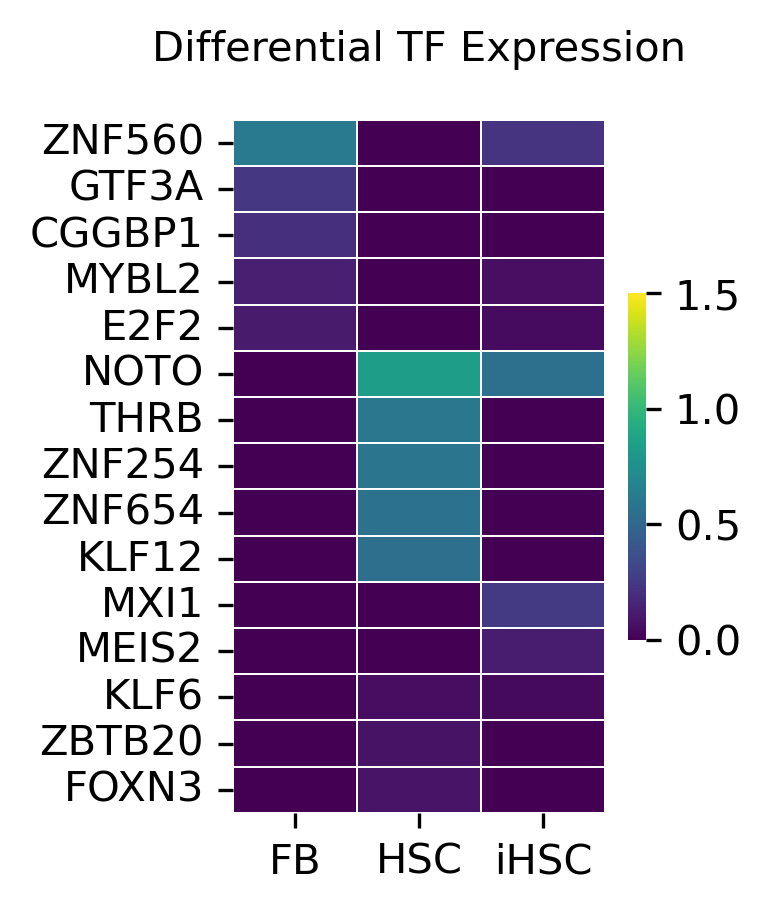

In [12]:
cmap = 'viridis'
n_genes = 5
values = 'logfoldchanges'
pct_nz_threshold = 0.5
pct_nz_reference = 0.85

table = top_n_de_genes(deg, 
                       n=n_genes, 
                       pct_nz_threshold=pct_nz_threshold,
                       pct_nz_reference=pct_nz_reference,
                       values=values)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 3

sns.heatmap(table.T, 
            cmap=cmap, 
            lw=0.1,
            vmin=0, 
            vmax=1.5,
            cbar_kws={'shrink' : 0.5})

plt.ylabel("")
plt.xlabel("")
plt.gca().tick_params(axis='y', rotation=0)
plt.title('Differential TF Expression', fontsize=10, y=1.05)

  cell_type gene_name
0        FB      SOX3
1        FB    ZNF560
2        FB      LHX2
3        FB    ZNF474
4        FB   NEUROG3


/tmp/ipykernel_2819423/2479654253.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X = X.groupby('cell_type').mean()


Text(0.5, 1.05, 'Differential TF Expression')

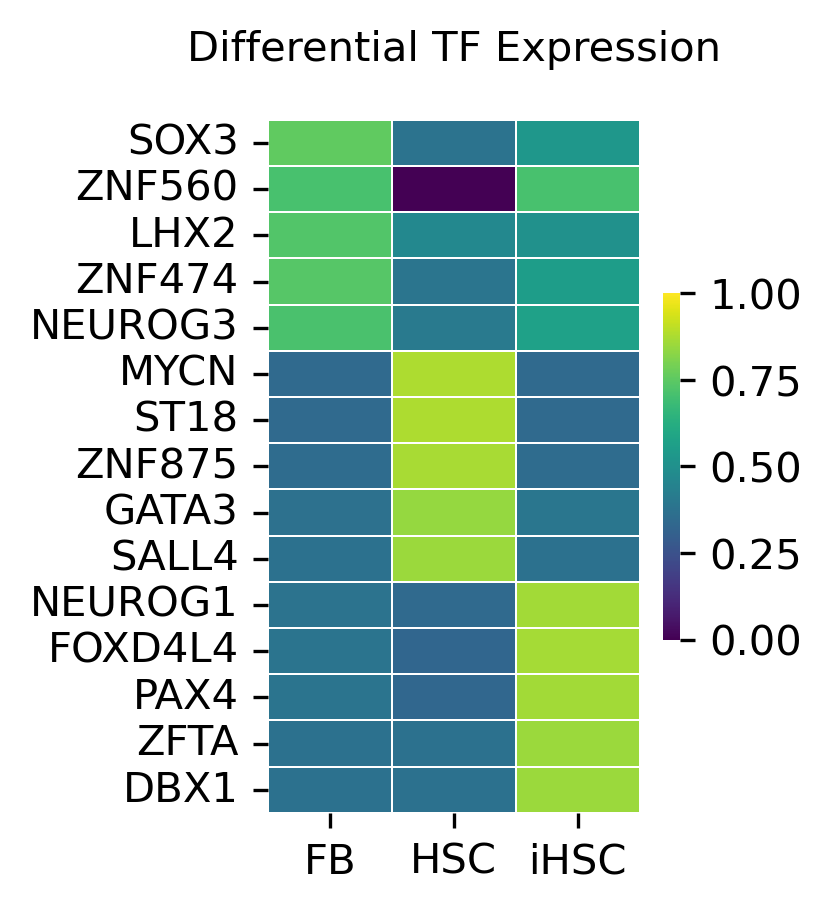

In [13]:
n_genes = 5
alpha = 0.01
lft = 0.01

test = get_top_genes(deg, n_genes=n_genes, 
                     lft=lft, alpha=alpha)

print(test.head())

X = tfdata[:, test['gene_name'].values].to_df()
X['cell_type'] = tfdata.obs['cell_type']
X = X.groupby('cell_type').mean()
genes = X.index
cells = X.columns

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 3

X = Normalizer().fit_transform(X.T)
X = pd.DataFrame(X, index=cells, columns=genes)

sns.heatmap(X, 
            cmap=cmap, 
            lw=0.1,
            vmin=0.0, 
            vmax=1,
            cbar_kws={'shrink' : 0.5})

plt.ylabel("")
plt.xlabel("")
plt.gca().tick_params(axis='y', rotation=0)
plt.title('Differential TF Expression', fontsize=10, y=1.05)

  cell_type gene_name
0        FB    ZNF837
1        FB    ZNF446
2        FB   ZSCAN32
3        FB    ZBTB48
4        FB    ZBTB43


/tmp/ipykernel_2819423/1127478557.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X = X.groupby('cell_type').mean()


Text(0.5, 1.05, 'Differential MR Expression')

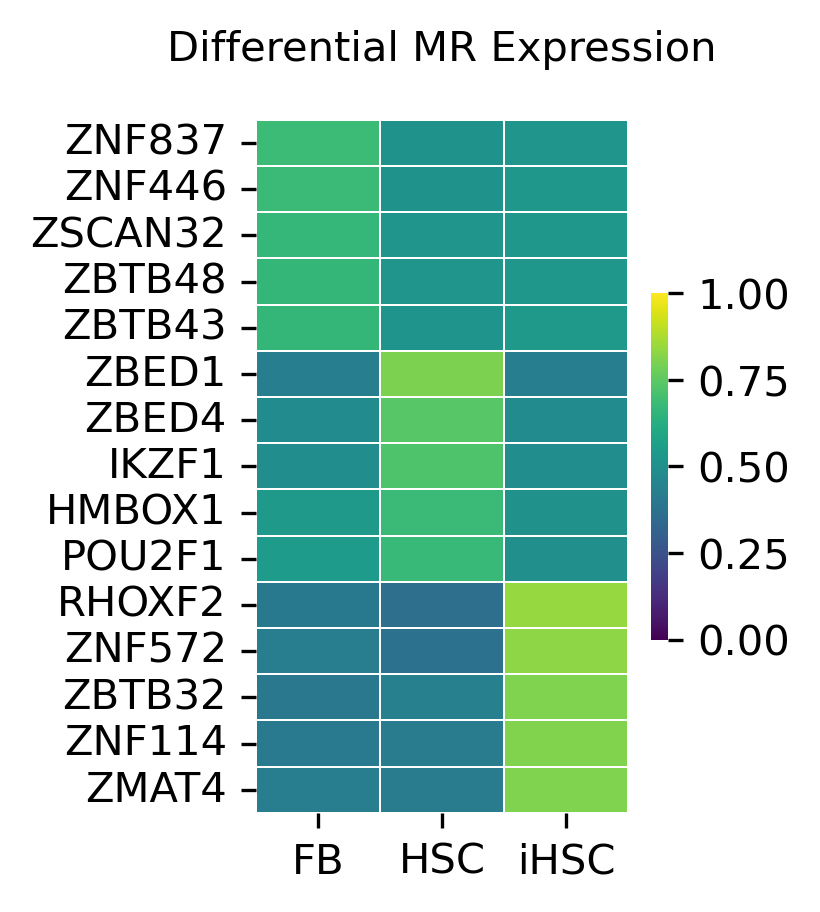

In [14]:
n_genes = 5
alpha = 0.05
lft = 0.00

test = get_top_genes(deg, n_genes=n_genes, 
                     gene_list=tdf[tdf['is_MR'] == "1"]['gene_name'].values,
                     lft=lft, alpha=alpha)

print(test.head())

X = tfdata[:, test['gene_name'].values].to_df()
X['cell_type'] = tfdata.obs['cell_type']
X = X.groupby('cell_type').mean()
genes = X.index
cells = X.columns

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 3

X = Normalizer().fit_transform(X.T)
X = pd.DataFrame(X, index=cells, columns=genes)

sns.heatmap(X, 
            cmap=cmap, 
            lw=0.1,
            vmin=0.0, 
            vmax=1,
            cbar_kws={'shrink' : 0.5})

plt.ylabel("")
plt.xlabel("")
plt.gca().tick_params(axis='y', rotation=0)
plt.title('Differential MR Expression', fontsize=10, y=1.05)

In [15]:
cmap = 'viridis'
n_genes = 5
values = 'logfoldchanges'
pct_nz_threshold = 0.5
pct_nz_reference = 0.3

table = top_n_de_genes(deg, 
                       n=n_genes, 
                       pct_nz_threshold=pct_nz_threshold,
                       pct_nz_reference=pct_nz_reference,
                       values=values,
                       gene_list=tdf[tdf['is_MR'] == "1"]['gene_name'].values)



# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 2, 3

# sns.heatmap(table.T, 
#             cmap=cmap, 
#             lw=0.1,
#             vmin=0, 
#             vmax=1,
#             cbar_kws={'shrink' : 0.5})

# plt.ylabel("")
# plt.xlabel("")
# plt.gca().tick_params(axis='y', rotation=0)

# Enrichment

In [16]:
n_genes = 100
alpha = 0.05
database = 'PanglaoDB_Augmented_2021'

test = get_top_genes(deg, n_genes=n_genes, lft=0.05, alpha=alpha)

for cell_type, group in test.groupby('cell_type'):
    print(f"\n====== {cell_type} ======")
    genes = group['gene_name'].to_list()
    
    edf = gget.enrichr(genes, database=database)
    edf = edf[edf['adj_p_val'] < alpha]
    
    for _, rec in edf.iterrows():
        print(f"{rec['path_name']} ({', '.join(rec['overlapping_genes'])})")
    
    



Mon May 27 12:48:02 2024 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021.



====== FB ======


Mon May 27 12:48:02 2024 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021.


Neural Stem/Precursor Cells (SOX3, DLX1, CSRNP3, SALL3, NHLH1, POU3F3, NPAS3)
Endothelial Cells (FOXF2, SOX17, FOXF1, MYF6, SOX7, MEOX1)

====== HSC ======


Mon May 27 12:48:03 2024 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021.


Hematopoietic Stem Cells (LYL1, MYCN, MECOM, TAL1, TFEC, GATA3, FLI1)
Epiblast Cells (CDX4, MYCN, BCL11A, SALL4, OTX2)

====== iHSC ======
Neural Stem/Precursor Cells (SOX1, ARX, DBX1, SP8, SOX21, NEUROG1)
Pluripotent Stem Cells (LIN28A, ZIC3, NKX1-2, PRDM14, HES3)
Pancreatic Progenitor Cells (ARX, ONECUT1, PTF1A, MNX1, NKX2-2)
Neuroblasts (SOX1, CUX2, ZIC3, SP8, NEUROG1)
Epiblast Cells (LIN28A, ZIC3, NKX1-2, HES3)


# A few plots

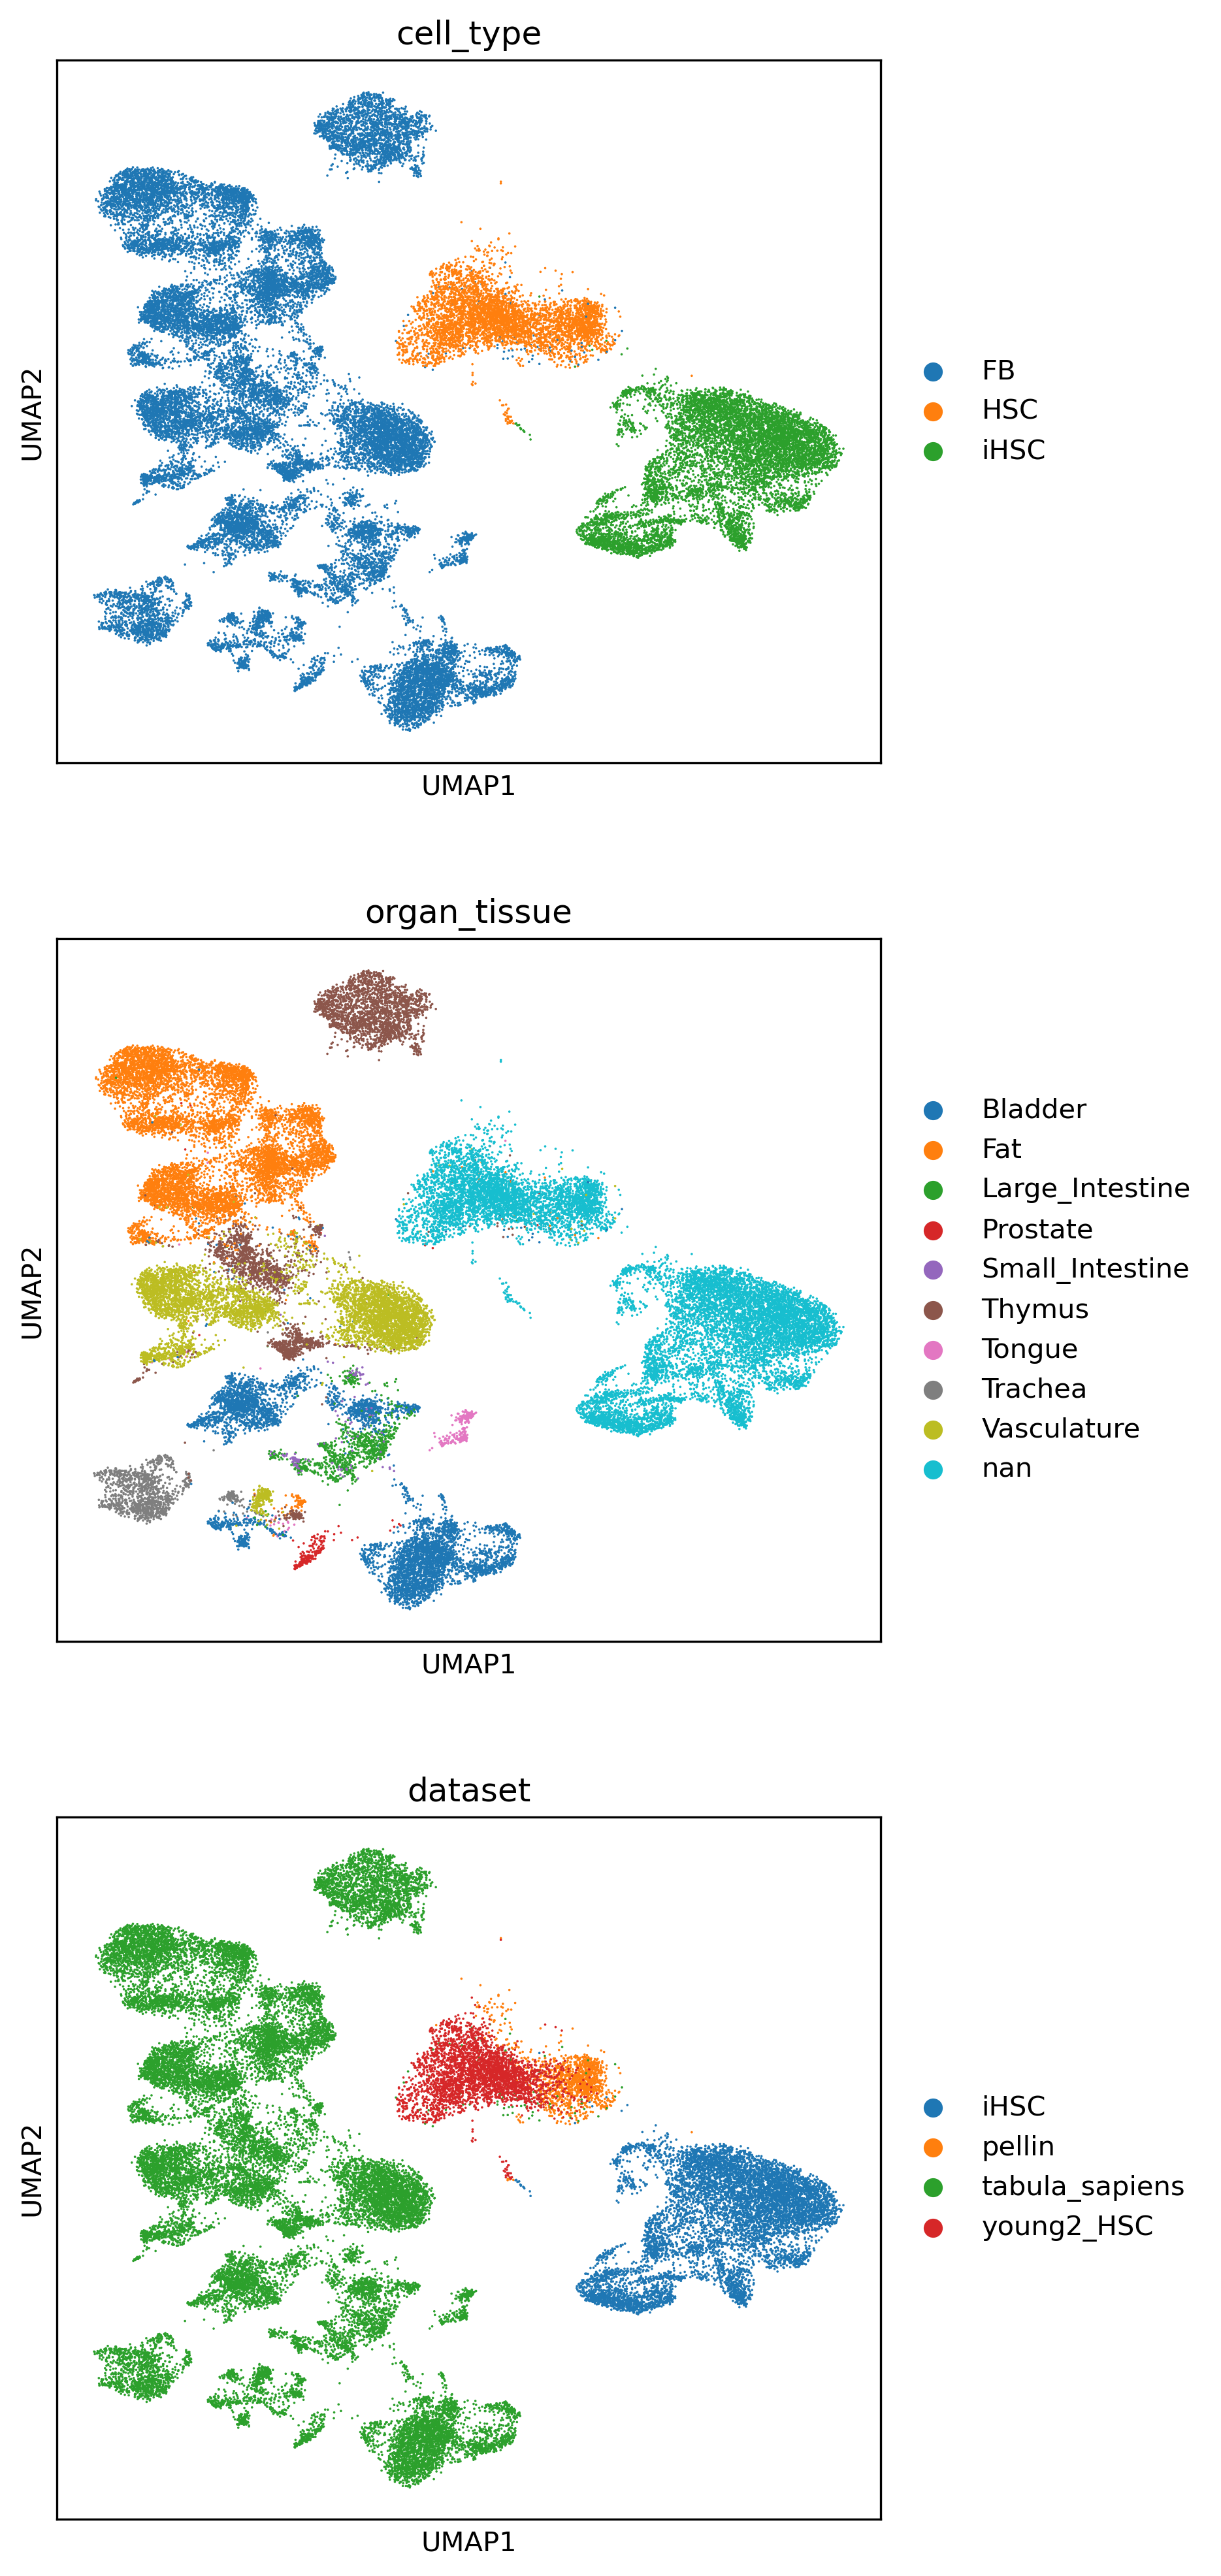

<Figure size 1500x1500 with 0 Axes>

In [22]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sc.pl.umap(tfdata,
           ncols=1, 
           color=['cell_type', 'organ_tissue', 'dataset'])

plt.tight_layout()

... storing 'cell_organ' as categorical


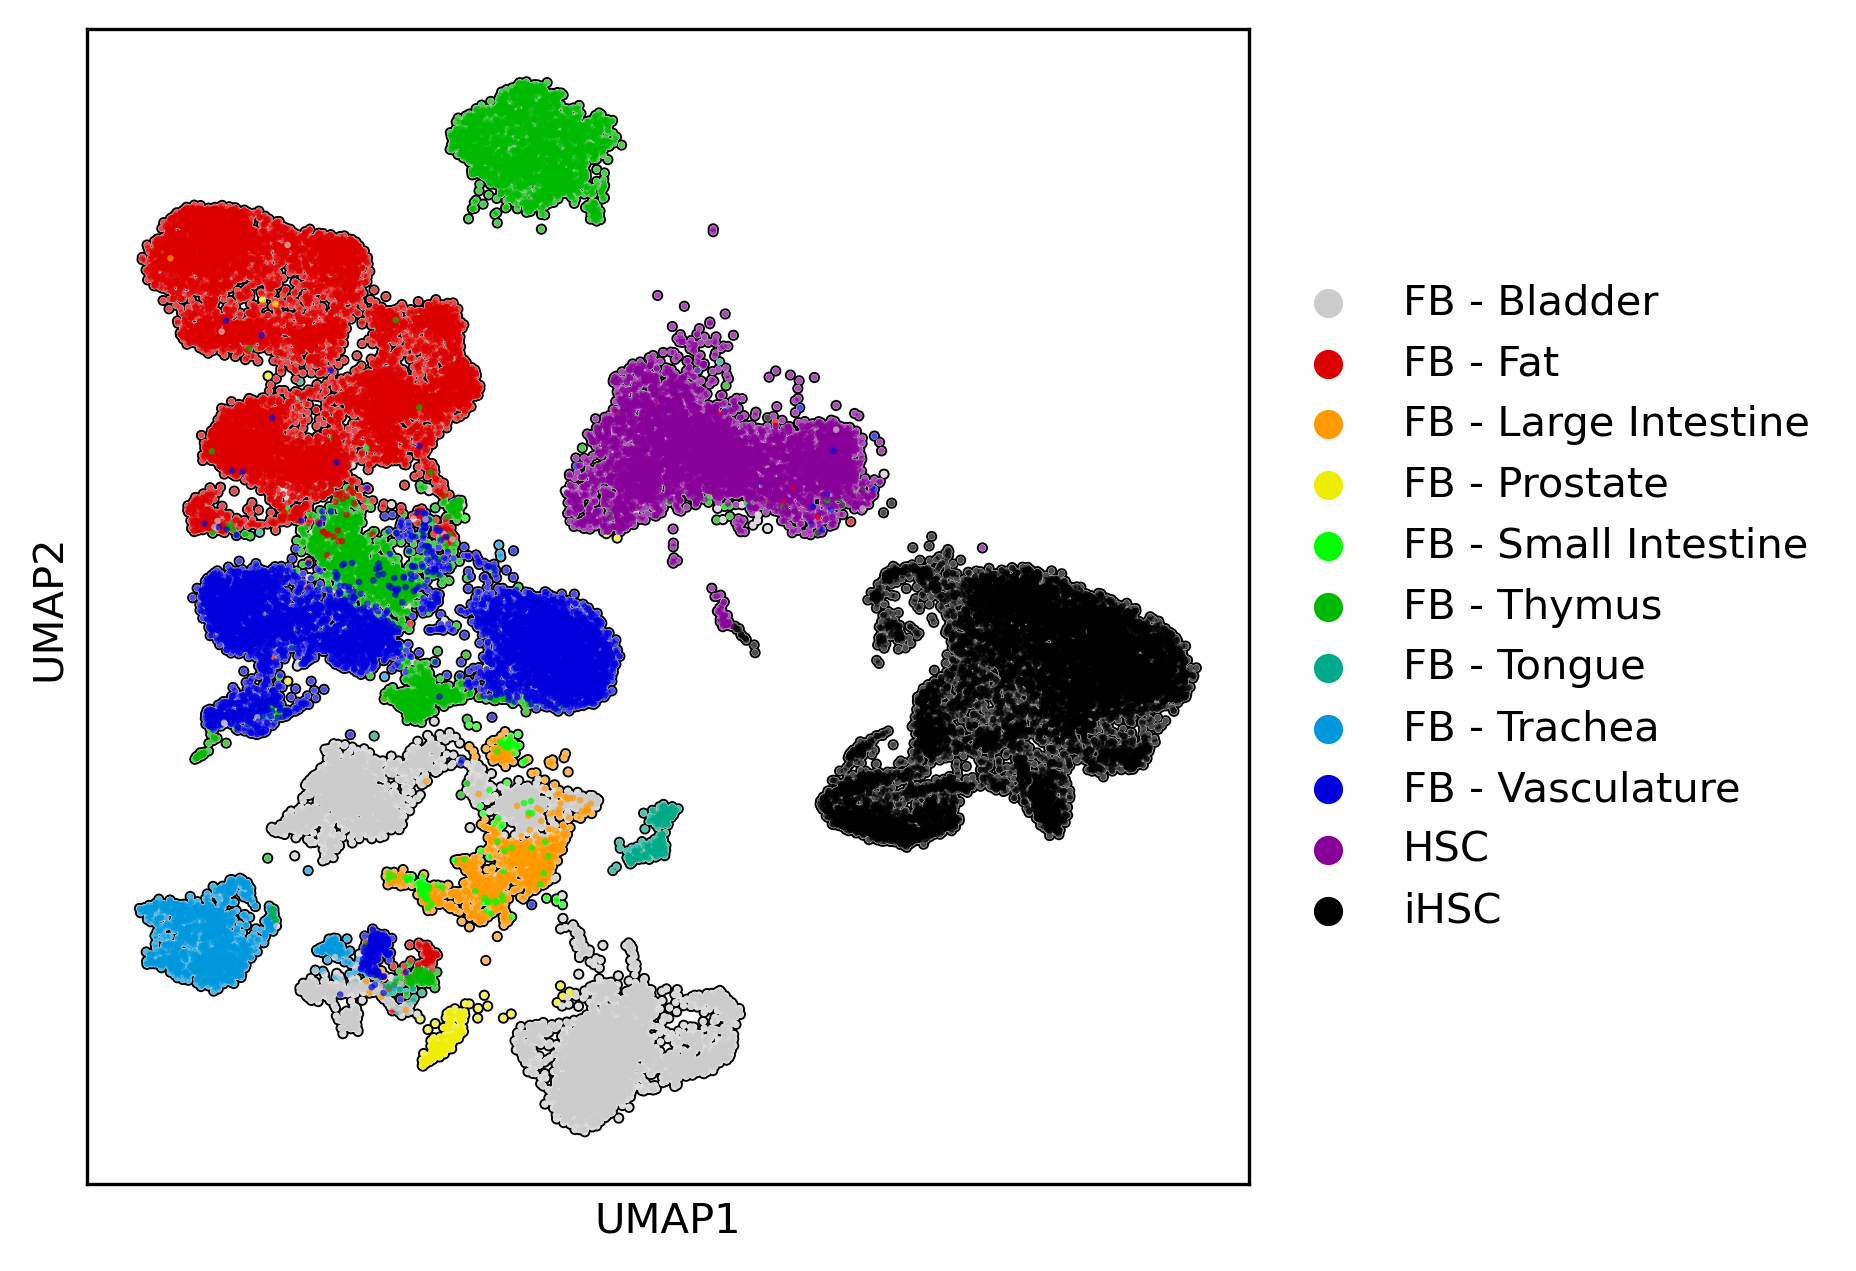

In [52]:
tfdata.obs['cell_organ'] = "FB - " + tfdata.obs['organ_tissue'].astype(str).str.replace("_", " ")
tfdata.obs['cell_organ'] = np.where(tfdata.obs['cell_organ'] == 'FB - nan',  tfdata.obs['cell_type'].astype(str), tfdata.obs['cell_organ'])

sc.pl.umap(tfdata, 
           color='cell_organ',
           palette='nipy_spectral_r',
           s=10,
           title="",
           add_outline=True)

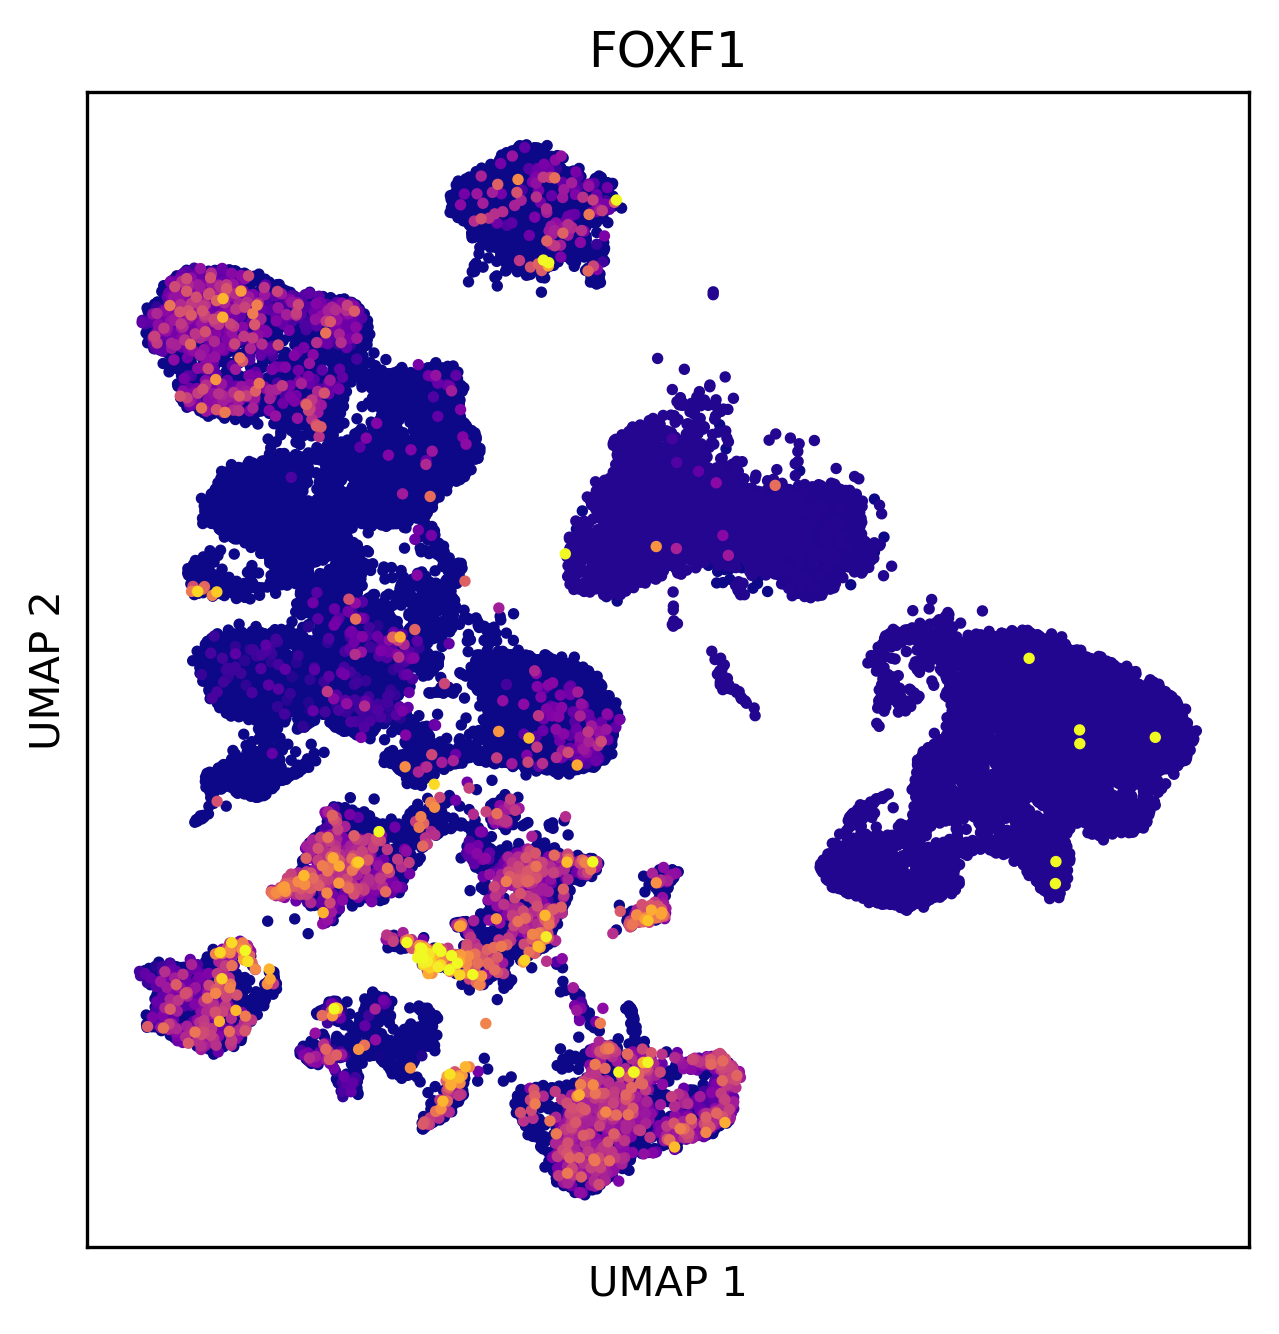

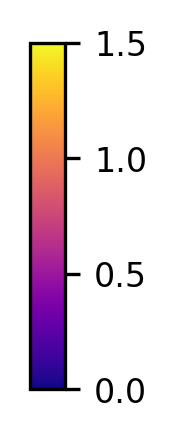

In [55]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

gene = "FOXF1"

plt2.plot_umap_scatter(tfdata, 
                       color=gene, 
                       title=gene,
                       vmin=0, 
                       vmax=1.5,
                       cmap='plasma',
                       s=3)

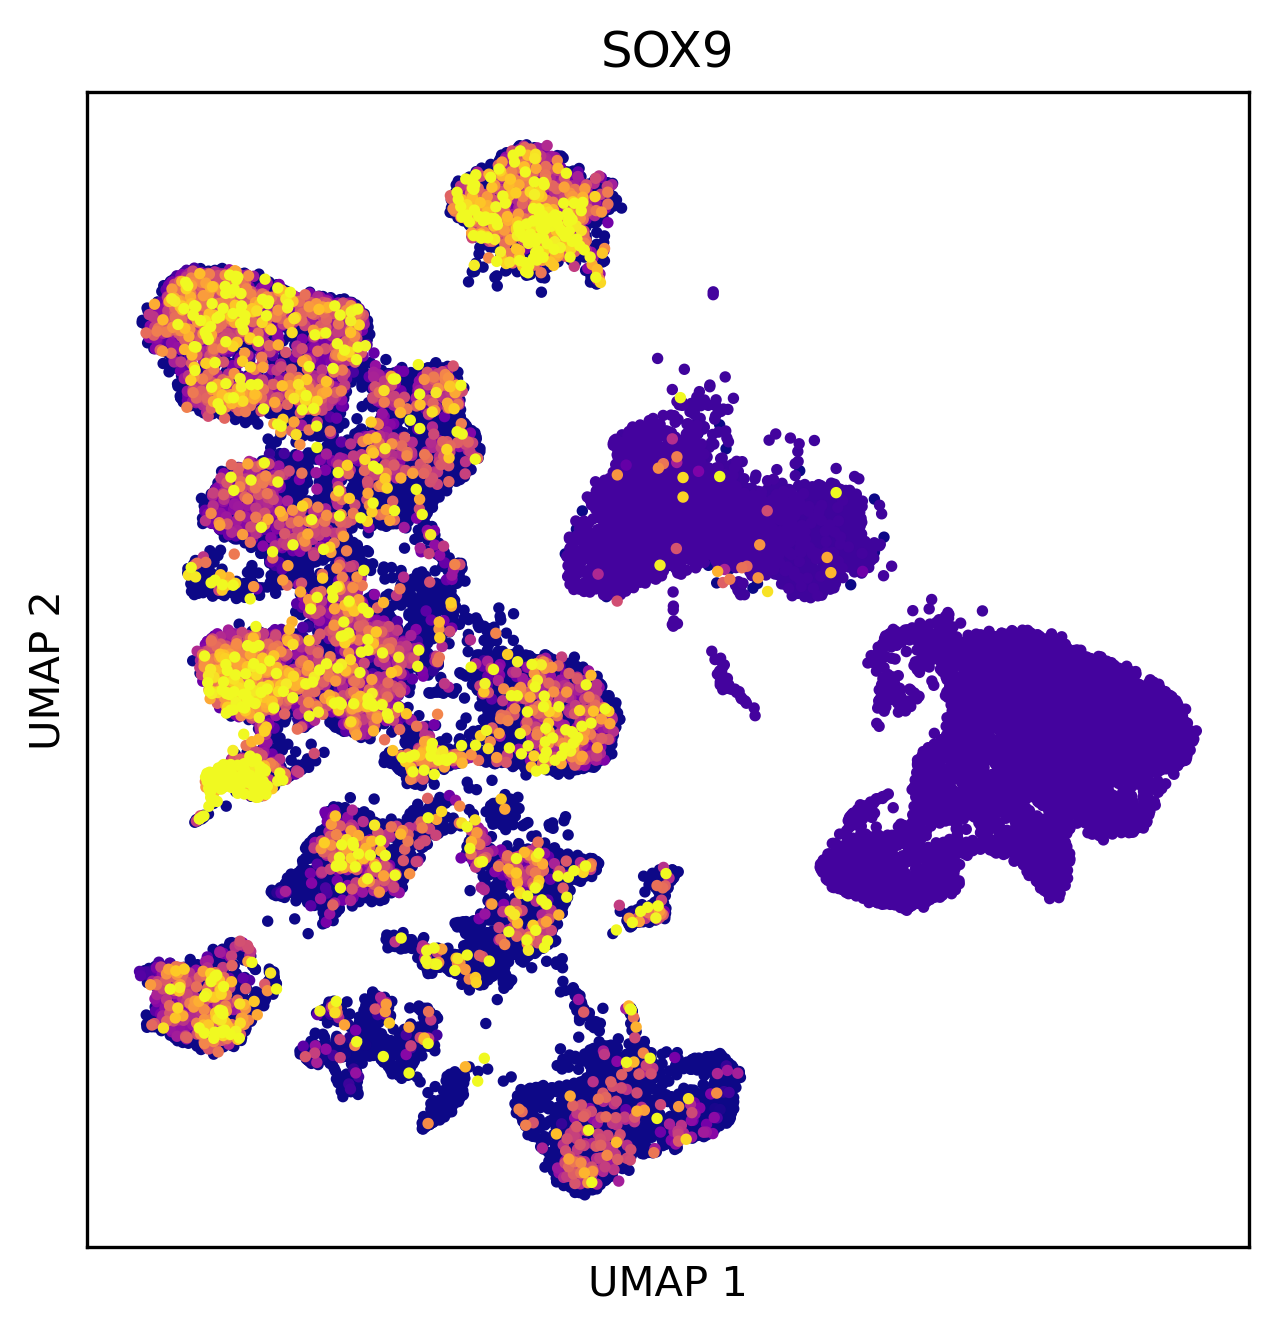

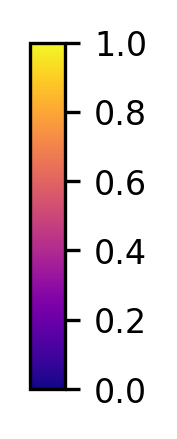

In [60]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

gene = "SOX9"

plt2.plot_umap_scatter(tfdata, 
                       color=gene, 
                       title=gene,
                       vmin=0, 
                       vmax=1,
                       cmap='plasma',
                       s=3)

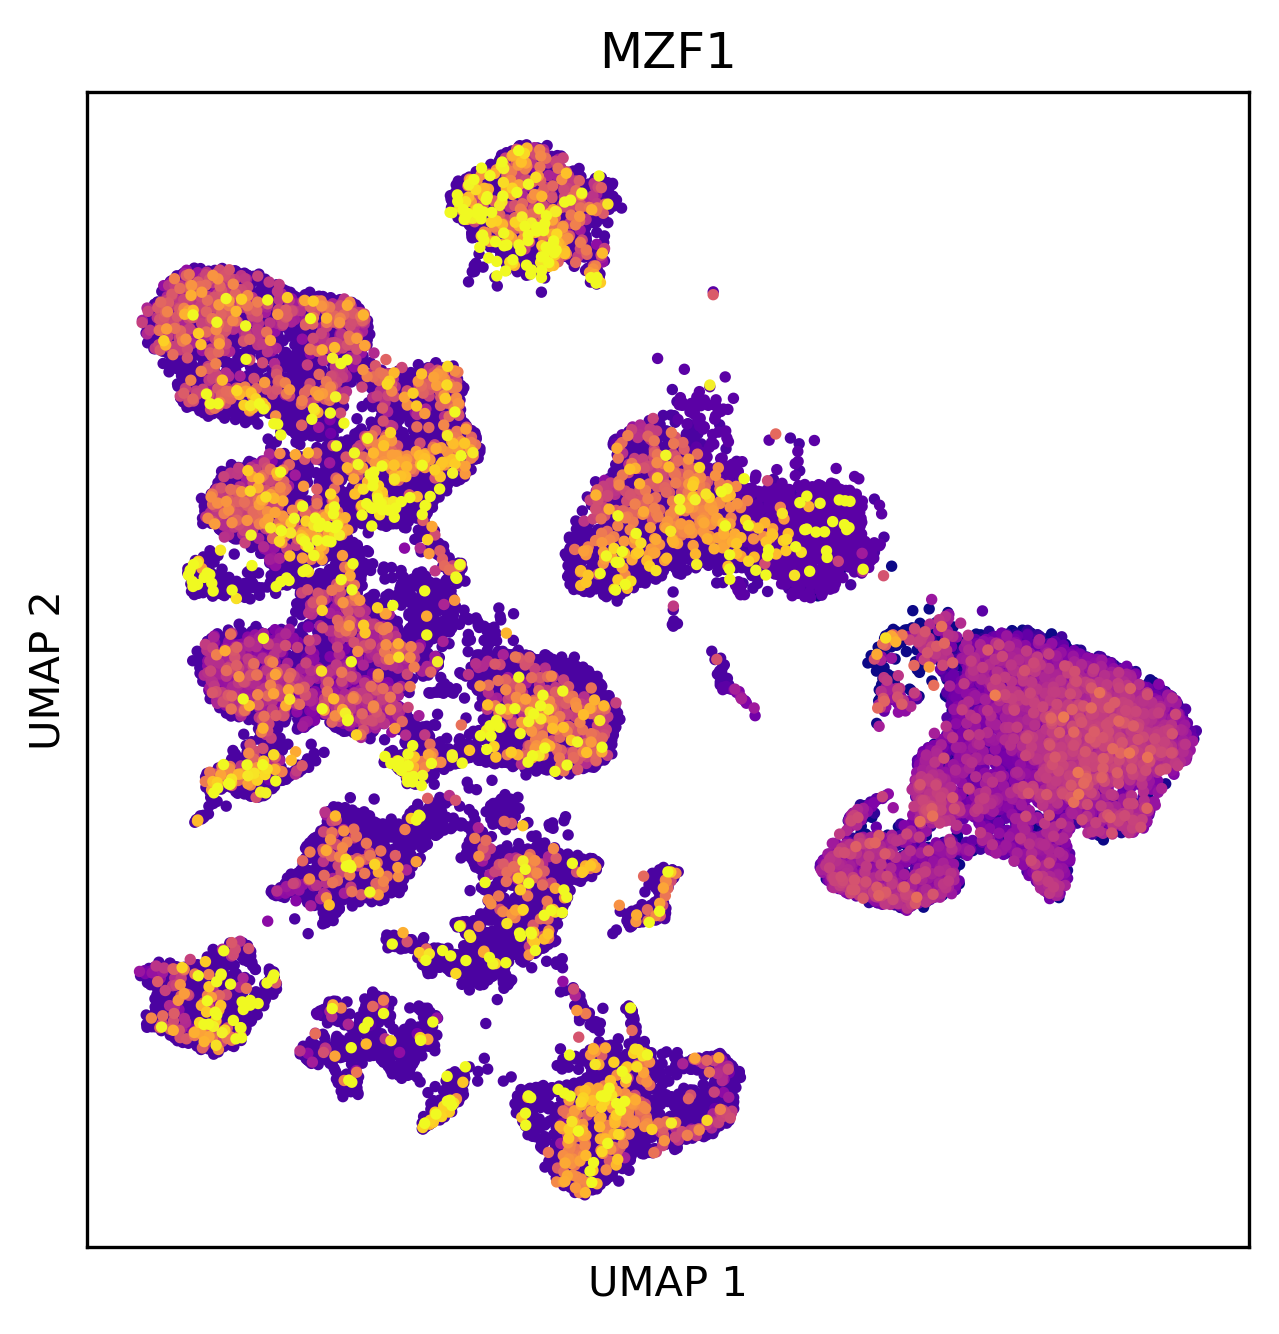

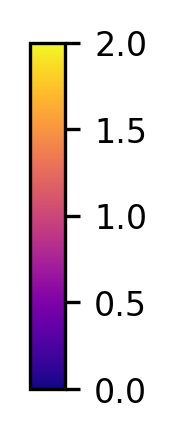

In [126]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

gene = "MZF1"

plt2.plot_umap_scatter(tfdata, 
                       color=gene, 
                       title=gene,
                       vmin=0, 
                       vmax=2,
                       cmap='plasma',
                       s=3)

In [97]:
pct_nz_group = 0.80
pvals_adj = 0.05

test = deg.copy()
test = test.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])
test = test[test['pct_nz_group'] > pct_nz_group]
test = test[test['pvals_adj'] <= pvals_adj]
test = test[~test['names'].str.startswith("ZN")]

test.groupby('group').head(10)

group    names      scores  logfoldchanges          pvals      pvals_adj  \
1440    FB    ATOH1 -130.469986        0.148946   0.000000e+00   0.000000e+00   
1438    FB   PHOX2A -130.469986        0.148823   0.000000e+00   0.000000e+00   
1439    FB    INSM1 -130.469986        0.148737   0.000000e+00   0.000000e+00   
1       FB     ANHX  162.251053        0.148708   0.000000e+00   0.000000e+00   
0       FB     PDX1  162.251053        0.148695   0.000000e+00   0.000000e+00   
869     FB    MYBL2  -49.859364        0.132876   0.000000e+00   0.000000e+00   
441     FB   ZBTB16   21.501001        0.124089  1.523617e-102  1.791899e-102   
11      FB     E2F2  161.508499        0.108826   0.000000e+00   0.000000e+00   
388     FB     NFIB   32.070408        0.103699  1.140477e-225  1.468422e-225   
422     FB     EGR1   24.480711        0.086583  2.370969e-132  2.879290e-132   
2239   HSC    TRPS1   36.379734        0.426752  8.904350e-290  1.717650e-289   
2588   HSC      ERG    2.779905        0.402878   5.437476e-03   5.791544e-03   
1675   HSC    SOX18  103.741096        0.360118   0.000000e+00   0.000000e+00   
1607   HSC  FOXD4L1  109.504768        0.359722   0.000000e+00   0.000000e+00   
2445   HSC    GTF2I   13.427114        0.357828   4.194455e-41   5.645433e-41   
2334   HSC    NCOA2   25.455690        0.338518  6.106181e-143  9.998170e-143   
2209   HSC     RFX3   42.083153        0.333963   0.000000e+00   0.000000e+00   
2394   HSC      FOS   17.396748        0.324402   8.732133e-68   1.255391e-67   
1608   HSC    ASCL5  109.448639        0.317134   0.000000e+00   0.000000e+00   
2439   HSC     NME2   13.838954        0.300797   1.483506e-43   2.011895e-43   
4035  iHSC     KLF1   15.467704        0.324775   5.731560e-54   6.543939e-54   
4003  iHSC   NFATC4   22.895998        0.293473  5.092994e-116  6.184901e-116   
3891  iHSC    ZFP82   46.763092        0.276753   0.000000e+00   0.000000e+00   
4009  iHSC   DMRTC2   22.291195        0.250991  4.498349e-110  5.425773e-110   
3976  iHSC   ZBTB21   29.119068        0.236705  2.059392e-186  2.577054e-186   
3977  iHSC    TCF21   28.944548        0.230009  3.286728e-184  4.109692e-184   
3968  iHSC     MZF1   30.852291        0.208485  5.219030e-209  6.587484e-209   
3957  iHSC     HES4   32.139191        0.190624  1.250599e-226  1.594837e-226   
3936  iHSC      VDR   36.363773        0.174556  1.591968e-289  2.076424e-289   
3982  iHSC     EBF3   27.653252        0.137062  2.550528e-168  3.162023e-168   

      pct_nz_group  pct_nz_reference  
1440      1.000000          0.902130  
1438      1.000000          0.902130  
1439      1.000000          0.902130  
1         1.000000          0.902130  
0         1.000000          0.902130  
869       1.000000          0.657302  
441       0.810276          1.000000  
11        1.000000          0.655470  
388       0.866546          1.000000  
422       0.872151          1.000000  
2239      0.822762          1.000000  
2588      0.842210          1.000000  
1675      1.000000          0.027218  
1607      1.000000          0.000739  
2445      0.809503          1.000000  
2334      0.822541          1.000000  
2209      0.843757          0.853072  
2394      0.950276          0.965899  
1608      1.000000          0.756968  
2439      0.834033          1.000000  
4035      0.808607          1.000000  
4003      0.800560          1.000000  
3891      0.822487          1.000000  
4009      0.844180          1.000000  
3976      0.862025          1.000000  
3977      0.862375          1.000000  
3968      0.851645          1.000000  
3957      0.871705          1.000000  
3936      0.880453          1.000000  
3982      0.899463          1.000000

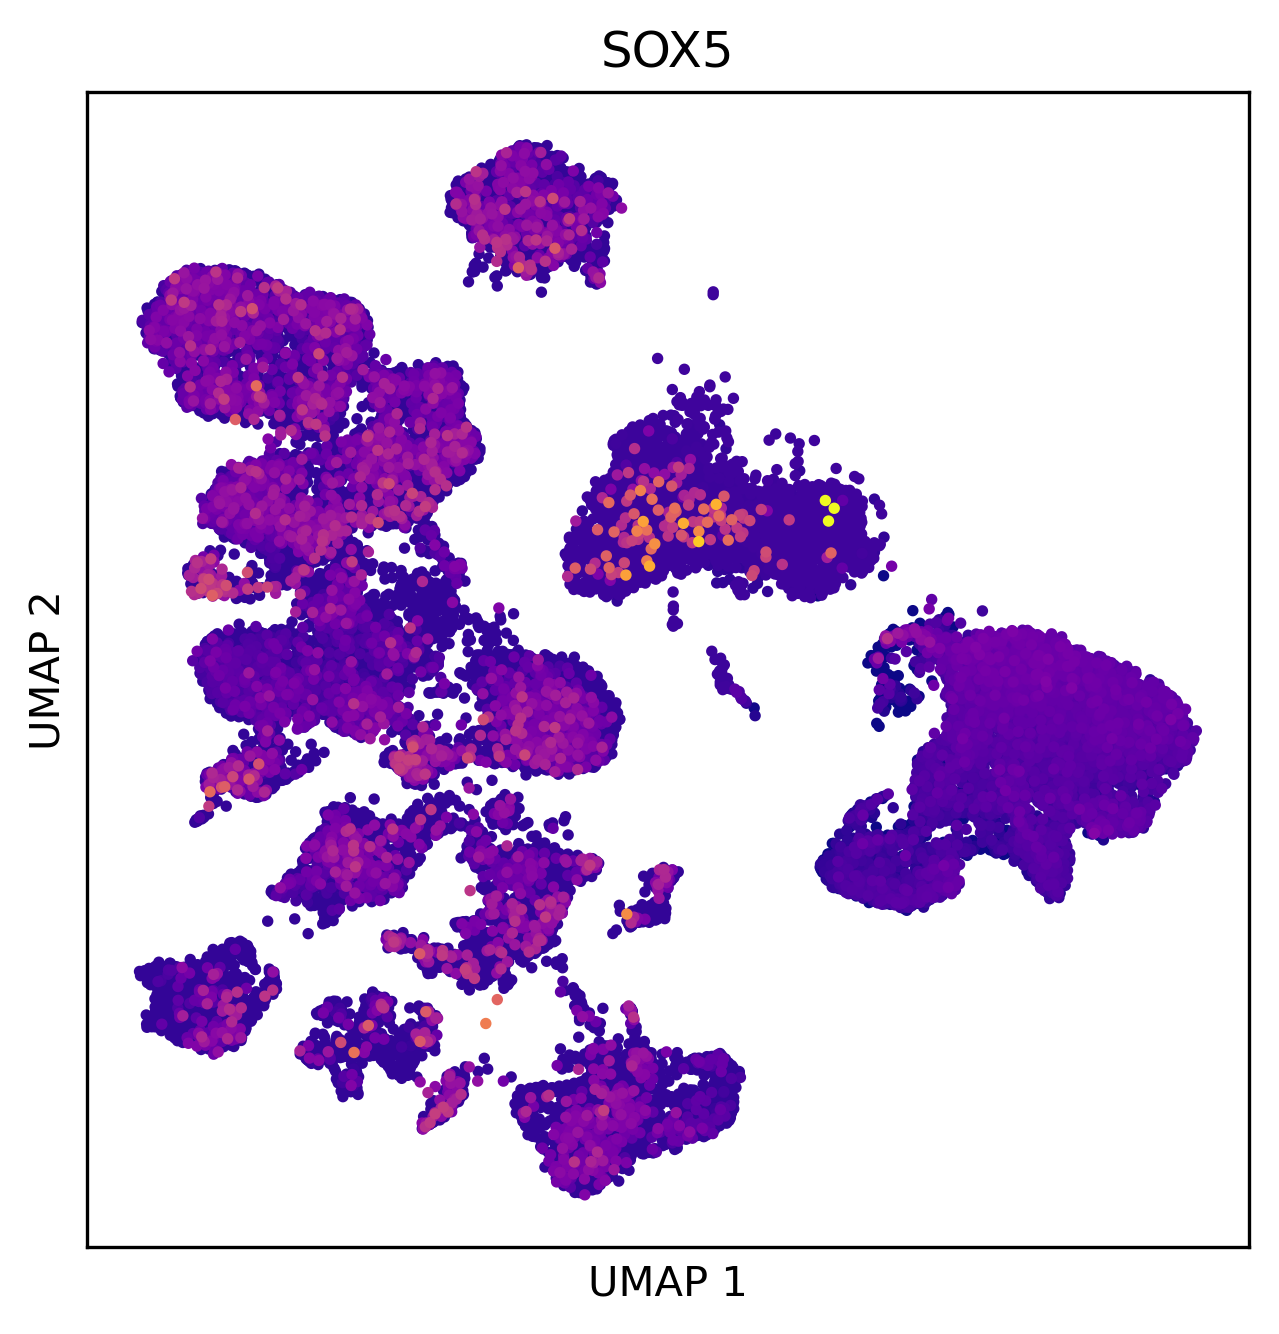

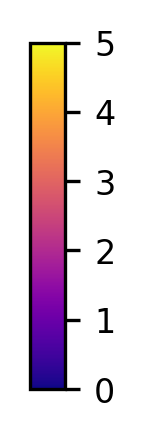

In [125]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

gene = "SOX5"

plt2.plot_umap_scatter(tfdata, 
                       color=gene, 
                       title=gene,
                       vmin=0, 
                       vmax=5,
                       cmap='plasma',
                       s=3)

In [115]:
pct_nz_group = 0.7
pvals_adj = 0.05

test = deg.copy()
test = test.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])
test = test[test['pct_nz_group'] > pct_nz_group]
test = test[test['pvals_adj'] <= pvals_adj]
test = test[test['names'].isin(tdf[tdf['is_MR'] == "1"]['gene_name'].values)]

test.groupby('group', sort=False).head(10)

group    names      scores  logfoldchanges          pvals      pvals_adj  \
494     FB    DRAP1   11.232133        0.193986   2.835508e-29   3.056704e-29   
439     FB     NFIX   21.876163        0.143779  4.381963e-106  5.168717e-106   
441     FB   ZBTB16   21.501001        0.124089  1.523617e-102  1.791899e-102   
1426    FB    IKZF3 -126.912537        0.004949   0.000000e+00   0.000000e+00   
953     FB     SOX5  -56.252087       -0.075843   0.000000e+00   0.000000e+00   
179     FB    IKZF1   85.253479       -0.236238   0.000000e+00   0.000000e+00   
393     FB  ZSCAN12   31.214605       -0.252391  6.751269e-214  8.623334e-214   
1027    FB    TBX15  -70.391548       -0.270494   0.000000e+00   0.000000e+00   
572     FB    THAP4   -4.150937       -0.324312   3.311173e-05   3.406810e-05   
451     FB   ZNF618   18.975578       -0.334363   2.715121e-80   3.140215e-80   
2416   HSC    TFDP2   15.200766        0.234804   3.495129e-52   4.876146e-52   
1901   HSC    ESRRG   76.978149        0.068603   0.000000e+00   0.000000e+00   
2174   HSC    IKZF3   46.604656       -0.014141   0.000000e+00   0.000000e+00   
2223   HSC     SOX5   40.025127       -0.026592   0.000000e+00   0.000000e+00   
3155   HSC  ZSCAN12  -82.560791       -0.096423   0.000000e+00   0.000000e+00   
2513   HSC    MEIS2    8.822596       -0.100014   1.118370e-18   1.357113e-18   
1917   HSC    THAP1   73.413452       -0.111906   0.000000e+00   0.000000e+00   
2877   HSC   ZBTB16  -16.287251       -0.124480   1.215736e-59   1.720057e-59   
2898   HSC     NFIX  -19.455051       -0.126561   2.640834e-84   3.898026e-84   
2044   HSC    CREB3   56.348221       -0.133682   0.000000e+00   0.000000e+00   
3974  iHSC    TBX15   29.350981        0.413718  2.321635e-189  2.914315e-189   
3980  iHSC  ZSCAN12   28.095524        0.372107  1.111078e-173  1.381736e-173   
3952  iHSC     SOX5   33.362694        0.113815  4.768357e-244  6.119837e-244   
3563  iHSC    IKZF3  109.018456        0.001945   0.000000e+00   0.000000e+00   
4002  iHSC    TFDP2   23.086042       -0.062288  6.394867e-118  7.771775e-118   
4206  iHSC   ZBTB16  -11.988581       -0.088625   4.078350e-33   4.518034e-33   
4466  iHSC    IKZF1  -91.784035       -0.103362   0.000000e+00   0.000000e+00   
4190  iHSC     NFIX   -9.970754       -0.113365   2.046691e-23   2.230351e-23   
3478  iHSC    ZBED4  120.320213       -0.116850   0.000000e+00   0.000000e+00   
4287  iHSC     BCL6  -23.475109       -0.134243  7.326275e-122  8.910485e-122   

      pct_nz_group  pct_nz_reference  
494       0.702550          1.000000  
439       0.744866          1.000000  
441       0.810276          1.000000  
1426      1.000000          0.903580  
953       1.000000          0.947935  
179       1.000000          0.828155  
393       1.000000          0.859455  
1027      1.000000          0.837698  
572       1.000000          0.617375  
451       1.000000          0.706313  
2416      0.836243          0.602247  
1901      0.719779          0.010410  
2174      0.720884          1.000000  
2223      1.000000          0.980603  
3155      1.000000          0.947639  
2513      1.000000          0.514505  
1917      1.000000          0.170677  
2877      1.000000          0.856542  
2898      1.000000          0.807082  
2044      1.000000          0.459727  
3974      0.752041          1.000000  
3980      0.785281          1.000000  
3952      0.920457          1.000000  
3563      1.000000          0.959403  
4002      1.000000          0.526663  
4206      1.000000          0.837871  
4466      1.000000          0.927646  
4190      1.000000          0.781974  
3478      1.000000          0.076468  
4287      1.000000          0.715374